In [1]:
!pip install umap-learn

In [1]:
import numpy as np
import torch
import math
import umap.umap_ as umap
import os
import pickle
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms
from pathlib import Path
import torch.nn.init as init
from torch.nn.parameter import Parameter
from torch.distributions.normal import Normal
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# DATA_DIR = '/content/drive/MyDrive/AML_project/datasets/FMNIST_DATASET'
DATA_DIR = '/tmp/vae_datasets'
BATCH_SIZE = 200
SEED = 42
LOAD_MODEL = False
NUM_MINIBATCHES = 4

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

if os.path.isdir(DATA_DIR):
    train_data = FashionMNIST(root=DATA_DIR, train=True, transform=transforms.ToTensor())
    test_data = FashionMNIST(root=DATA_DIR, train=False, transform=transforms.ToTensor())
else:
    os.mkdir(DATA_DIR)
    train_data = FashionMNIST(root=DATA_DIR, train=True, download=True, transform=transforms.ToTensor())
    test_data = FashionMNIST(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=1,
                          drop_last=True)

test_loader = DataLoader(test_data,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=1,
                         drop_last=False)

fmnist_classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [14]:
def display(images, length):
    f, axes = plt.subplots(1, length, sharex='col', sharey='row')
    plt.figure(figsize=(18, 6))
    for i, image in enumerate(images):
        image = image.data.cpu().view(28, 28)
        if len(images) > 1:
            _ = axes[i].imshow(image, cmap='gray')
        else:
            _ = axes.imshow(image, cmap='gray')
def reparametrize(mu, std, device):
    """
    Performs reparameterization trick z = mu + epsilon * std
    Where epsilon~N(0,1)
    """
    mu = mu.expand(1, *mu.size())
    std = std.expand(1, *std.size())
    eps = torch.normal(0, 1, size=std.size()).to(device)
    return mu + eps * std

class FMNIST_VANILA_VAE(nn.Module):
    """
    Just your regular variational auto encoder (not IB)
    """
    def __init__(self, k, device):
        super(FMNIST_VANILA_VAE, self).__init__()
        self.device = device
        self.description = 'Vanilla IB VAE as per the paper'
        self.k = k
        self.train_loss = []
        self.test_loss = []

        self.encoder = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2 * self.k))

        self.decoder = nn.Sequential(
                nn.Linear(self.k, 1024),
                nn.ReLU(True),
                nn.Linear(1024, 28*28),
                nn.Sigmoid())

        # Xavier initialization
        for _, module in self._modules.items():
            for layer in module:
                if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                            nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('relu'))
                            layer.bias.data.zero_()

    def forward(self, x):
        # squiwsh from shape (100,1,28,28) to (100,784)
        x = x.view(x.size(0),-1)
        z_params = self.encoder(x)
        mu = z_params[:, :self.k]
        # softplus transformation (soft relu) and a -5 bias is added as in the paper
        std = F.softplus(z_params[:, self.k:] - 5, beta=1)
        if self.training:
            z = reparametrize(mu, std, self.device)
        else:
            z = mu.clone().unsqueeze(0)
        decoded = self.decoder(z)
        return (mu, std), decoded[0]

def general_gaussians_kld(mu1, mu2, std1, std2):
    # https://discuss.pytorch.org/t/kl-divergence-between-two-multivariate-gaussian/53024/8
    # Assuming diagonal covariance
    sigma1 = torch.diag_embed(std1 ** 2)
    sigma2 = torch.diag_embed(std2 ** 2)
    sigma2_inverse = torch.linalg.inv(sigma2)
    term1 = torch.log(sigma2.det() + 1e-8) - torch.log(sigma1.det() + 1e-8)
#     term2 = torch.trace(torch.bmm(sigma2_inverse, sigma1))
    term2 = torch.bmm(sigma2_inverse, sigma1).diagonal(offset=0, dim1=-1, dim2=-2).sum(-1)
#     term3 = (mu2 - mu1) @ sigma2_inverse @ (mu2 - mu1)
    term3 = torch.bmm(torch.bmm((mu2 - mu1).unsqueeze(1), sigma2_inverse), (mu2 - mu1).unsqueeze(2))
    return 0.5 * (term1 -1 + term2 + term3)
    
def vae_loss(x_hat, x, mu, std, beta):
    reconstruction_loss = F.mse_loss(x_hat.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    normalization_loss = -0.5 * (1 + 2 * std.log() - mu.pow(2) - std.pow(2)).sum()
    # KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    return reconstruction_loss + beta * normalization_loss

def kl_divergence_gaussian(mean_q, std_q, mean_p, std_p):
    """
    Computes the KL divergence between two multivariate Gaussian distributions with diagonal covariance matrices.
    
    Args:
        mean_q (torch.Tensor): Mean of the first Gaussian distribution (shape: [batch_size, num_dimensions]).
        std_q (torch.Tensor): Standard deviation of the first Gaussian distribution (shape: [batch_size, num_dimensions]).
        mean_p (torch.Tensor): Mean of the second Gaussian distribution (shape: [batch_size, num_dimensions]).
        std_p (torch.Tensor): Standard deviation of the second Gaussian distribution (shape: [batch_size, num_dimensions]).
        
    Returns:
        torch.Tensor: KL divergence between the two distributions (shape: [batch_size]).
    """
    num_dimensions = mean_q.shape[1]
    
    # Compute the diagonal covariance matrices for both distributions
    cov_q = torch.diag_embed(std_q**2)
    cov_p = torch.diag_embed(std_p**2)
    
    # Compute the inverse of the covariance matrix of the second distribution
    cov_q_inv = torch.inverse(cov_q)
    
    # Compute the trace term of the KL divergence
    trace_term = torch.sum(cov_q_inv * cov_q, dim=(1,2))
    
    # Compute the difference between the means
    mean_diff = mean_p - mean_q
    
    # Compute the quadratic term of the KL divergence
    quadratic_term = torch.sum(mean_diff.unsqueeze(-1) * torch.matmul(cov_q_inv, mean_diff.unsqueeze(-1)), dim=(1,2))
    
    # Compute the log determinant term of the KL divergence
    logdet_term = torch.sum(torch.log(cov_q.det() + 1e-8) - torch.log(cov_p.det() + 1e-8), dim=-1)
    
    # Compute the KL divergence
    kl_div = 0.5 * (trace_term + quadratic_term - num_dimensions + logdet_term)
    
    return kl_div



In [15]:
def loop_data(model, dataloader, beta,
              is_train, model_save_path, epochs,
              device, optimizer=None, scheduler=None, eta=0.001):
    """
    loops over the dataset, collects metrics and train 
    a model if is_train is True
    """
    if is_train:
        model.train()
    else:
        model.eval()
        epochs = 1

    for e in range(epochs):
        epoch_loss = 0        
        for batch_num, (images, labels) in enumerate(dataloader):
            # Compute base z distribution
            x = images.to(device)
            y = labels.to(device)
            (mu, std), decoded = model(x)
            batch_loss = vae_loss(decoded.view(-1, 28*28), x.view(-1, 28*28), mu, std, beta)
                
            if is_train:
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            epoch_loss += batch_loss.item()

            if is_train and (batch_num % 100) == 0:
                print('batch loss:{:.2f}'.format(batch_loss.item()))
        
        epoch_loss /= batch_num
        if is_train:
            model.train_loss.append(epoch_loss)
        else:
            model.test_loss.append(epoch_loss)
        
        if len(model.test_loss) > 1 and not is_train:
            if (epoch_loss < min(model.test_loss)):
                torch.save(model, model_save_path)
                print('Saved model to {}'.format(model_save_path))

        if not is_train:
            print('[TEST RESULTS]')
            print('epoch loss:{:.2f}'.format(epoch_loss))


In [16]:
# MODEL_SAVE_PATH = '/content/drive/MyDrive/AML_project/saved_models/fmnist_vanilla_vae.h5'
MODEL_SAVE_PATH = '/users/nirweingarten/Desktop/junk/fmnist_vanilla_vae.h5'
K = 256
LR = 1e-4
EPOCHS = 100
BETA = 1e-3

model = FMNIST_VANILA_VAE(K, device).to(device)
optimizer = optim.Adam(model.parameters(), LR, betas=(0.5,0.999))
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

for epoch in range(EPOCHS):
    loop_data(model, train_loader, BETA, is_train=True, 
              model_save_path=MODEL_SAVE_PATH, epochs=1, device=device,
              optimizer=optimizer, scheduler=scheduler)

    loop_data(model, test_loader, BETA, is_train=False, 
              model_save_path=MODEL_SAVE_PATH, epochs=1, device=device,
              optimizer=optimizer, scheduler=scheduler)

    if (epoch % 2) == 0 and (epoch != 0):
        scheduler.step()

print("----- Training complete -----")

batch loss:30293.46
batch loss:5420.70
batch loss:3996.36
[TEST RESULTS]
epoch loss:3548.70
batch loss:3377.12
batch loss:3122.13
batch loss:2803.73
[TEST RESULTS]
epoch loss:2650.94
batch loss:2655.70
batch loss:2416.85
batch loss:2362.13
[TEST RESULTS]
epoch loss:2217.22
batch loss:2216.69
batch loss:2141.38
batch loss:2000.01
[TEST RESULTS]
epoch loss:1924.06
batch loss:1935.34
batch loss:2125.02
batch loss:1773.56
[TEST RESULTS]
epoch loss:1751.85
batch loss:1746.84
batch loss:1760.09
batch loss:2182.35
[TEST RESULTS]
epoch loss:1609.46
batch loss:1580.96
batch loss:1436.93
batch loss:1843.46
[TEST RESULTS]
epoch loss:1586.71
batch loss:1546.57
batch loss:1604.68
batch loss:1363.43
[TEST RESULTS]
epoch loss:1559.18
batch loss:1401.59
batch loss:1321.83
batch loss:1388.42
[TEST RESULTS]
epoch loss:1377.38
batch loss:1307.32
batch loss:1234.07
batch loss:1282.98
[TEST RESULTS]
epoch loss:1266.72
batch loss:1282.56
batch loss:1251.73
batch loss:1283.85
[TEST RESULTS]
epoch loss:1251.2

batch loss:558.32
[TEST RESULTS]
epoch loss:585.64
batch loss:564.48
batch loss:559.49
batch loss:596.10
[TEST RESULTS]
epoch loss:577.14
batch loss:594.58
batch loss:554.68
batch loss:539.93
[TEST RESULTS]
epoch loss:577.63
batch loss:531.22
batch loss:546.92
batch loss:537.32
[TEST RESULTS]
epoch loss:579.03
batch loss:565.82
batch loss:534.53
batch loss:574.55
[TEST RESULTS]
epoch loss:575.03
batch loss:534.97
batch loss:526.26
batch loss:538.55
[TEST RESULTS]
epoch loss:574.96
batch loss:556.73
batch loss:513.44
batch loss:557.34
[TEST RESULTS]
epoch loss:572.56
----- Training complete -----


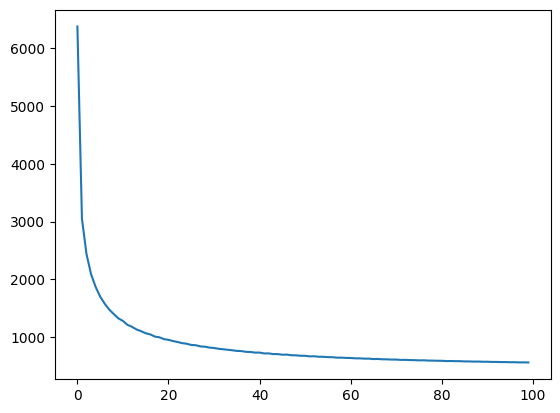

In [17]:
plt.plot(model.train_loss)

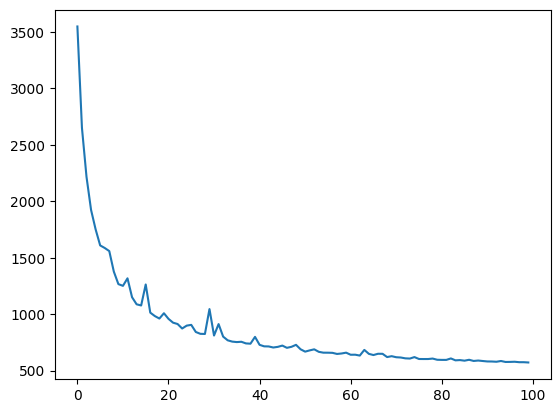

In [18]:
plt.plot(model.test_loss)

In [19]:
model.test_loss[-1]

572.5600972078284

In [320]:
# kl_divergence_gaussian(torch.tensor([[0,0]], dtype=torch.float), torch.tensor([[1,1]], dtype=torch.float), torch.tensor([[0,0]], dtype=torch.float), torch.tensor([[2,1]], dtype=torch.float))

mu1 = torch.tensor([[1]], dtype=torch.float)
std1 = torch.tensor([[2]], dtype=torch.float)
mu2 = torch.tensor([[1]], dtype=torch.float)
std2 = torch.tensor([[1]], dtype=torch.float)


mu3 = torch.tensor([[1], [1]], dtype=torch.float)
std3 = torch.tensor([[2], [2]], dtype=torch.float)
mu4 = torch.tensor([[1], [1]], dtype=torch.float)
std4 = torch.tensor([[1], [1]], dtype=torch.float)

# kl_divergence_gaussian(mu1, std1, mu2, std2)


In [321]:
n1 = Normal(mu1, std1)
n2 = Normal(mu2, std2)
n3 = Normal(mu3, std3)
n4 = Normal(mu4, std4)

torch.distributions.kl_divergence(n1, n2)
torch.distributions.kl_divergence(n3, n4)

# n.log_prob(torch.tensor([0,0], dtype=torch.float))

tensor([[0.8069]])

tensor([[0.8069],
        [0.8069]])

In [202]:
n.log_prob(z).mean(axis=-1).shape

torch.Size([200])

In [199]:
n.log_prob(z).shape

torch.Size([200, 256])

In [196]:
torch.any(n.log_prob(z) >= 1) #.exp()

tensor(False)

In [175]:
n = Normal(torch.tensor([0,1]), torch.tensor([1, 1]))
p = n.log_prob(torch.tensor([[-1,2],[0,0]], dtype=torch.float))

In [176]:
p.exp()

tensor([[0.2420, 0.2420],
        [0.3989, 0.2420]])

In [106]:
term3 = (mu2 - mu1) @ sigma2_inverse @ (mu2 - mu1)

torch.matmul((mu2 - mu1).T, sigma2_inverse)

torch.matmul((mu2 - mu1).unsqueeze(1), sigma2_inverse)  # 200, 1, 256


torch.bmm(torch.matmul((mu2 - mu1).unsqueeze(1), sigma2_inverse), mu1-mu2)


torch.matmul(torch.matmul((mu2 - mu1).unsqueeze(1), sigma2_inverse), mu2 - mu1)

torch.matmul(mu2 - mu1, torch.matmul((mu2 - mu1).unsqueeze(1), sigma2_inverse))


v = torch.tensor([2,3,4], dtype=torch.float)

V = v.diag()

V.trace()
V.det()

V @ torch.ones_like(v)


V.diagonal(offset=0, dim1=-1, dim2=-2).sum(-1)


tensor(9.)

tensor(24.)

tensor([2., 3., 4.])

tensor(9.)

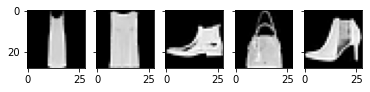

<Figure size 1296x432 with 0 Axes>

In [83]:
display(images[0:5], 5)

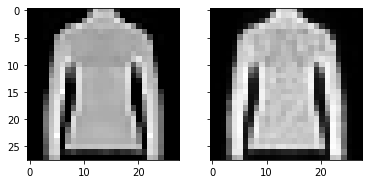

<Figure size 1296x432 with 0 Axes>

In [108]:
I = 23
x = images[I]
(_, _), x_hat = model(x.cuda())
x_hat = x_hat.view(-1, 28*28)
display([x, x_hat], 2)

In [192]:
latent_list = []
label_list = []
label_text_list = []
model.eval()
for idx, (image_batch, label_batch) in enumerate(train_loader):
    with torch.no_grad():
        (mu, _), _ = model(image_batch.to(device))
        latent_list += [mu1.unsqueeze(0).cpu() for mu1 in mu]
    label_list += [int(label) for label in label_batch]
    label_text_list += [fmnist_classes[int(label)] for label in label_batch]
    if idx > 100:
        break
latent_array = np.array([tensor.cpu().numpy()[0] for tensor in latent_list])

In [193]:
reducer = umap.UMAP()
scaler = StandardScaler().partial_fit(latent_array)
scaled_data = scaler.transform(latent_array)
embedding = reducer.fit_transform(scaled_data)

Text(0.5, 1.0, 'Casted latent instances')

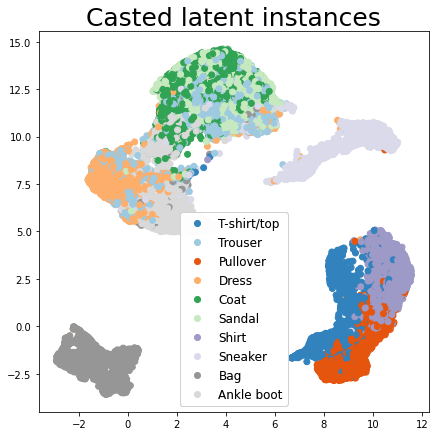

In [200]:
labels = pd.Series(label_text_list)
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
c = [[c for c in range(1,11)][x] for x in labels\
       .map({label: i for i, label in enumerate(labels.unique())})]

scatter = axes.scatter(
                    embedding[:, 0],
                    embedding[:, 1],
                    c=c,
                    cmap='tab20c')

# TODO: fix legend real class correlation
legend1 = axes.legend(scatter.legend_elements()[0],\
                    [text for text in fmnist_classes],\
                    fontsize=18, prop={'size': 12})

axes.add_artist(legend1)
fig.canvas.draw()
axes.set_title('Casted latent instances', fontsize=25)
# plt.savefig('test.png')

### Generate some instaces

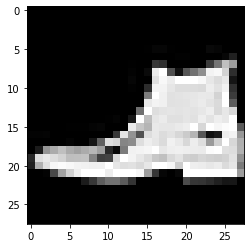

<Figure size 1296x432 with 0 Axes>

In [213]:
display(images[2], 1)

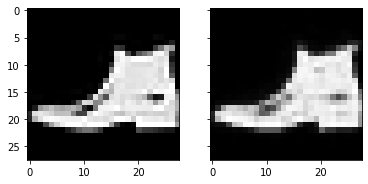

<Figure size 1296x432 with 0 Axes>

In [256]:
# i = np.random.randint(0,199)
i = 2
(mu, sigma), _ = model(images[i].to(device))
z1 = torch.normal(mu, sigma).to(device)
sample = model.decoder(z1)
display([images[i], sample], 2)

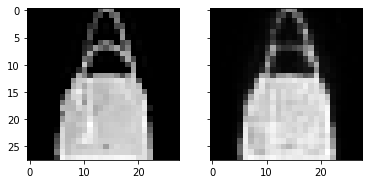

<Figure size 1296x432 with 0 Axes>

In [257]:
# i = np.random.randint(0,199)
i = 3
(mu, sigma), _ = model(images[i].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder(z2)
display([images[i], sample], 2)

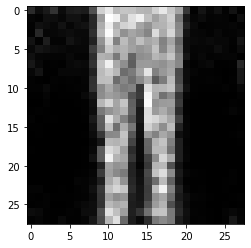

<Figure size 1296x432 with 0 Axes>

In [266]:
inv_transformed_points = reducer.inverse_transform([[-1,-2]])
sample = model.decoder(torch.tensor(inv_transformed_points).to(device))
display([sample], 1)

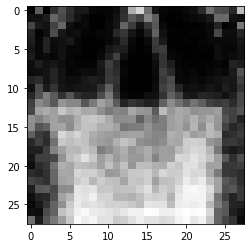

<Figure size 1296x432 with 0 Axes>

In [268]:
inv_transformed_points = reducer.inverse_transform([[7,8]])
sample = model.decoder(torch.tensor(inv_transformed_points).to(device))
display([sample], 1)

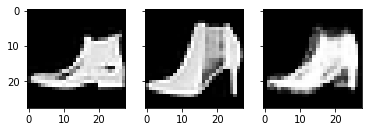

<Figure size 1296x432 with 0 Axes>

In [277]:
i1=2
i2=4
(mu, sigma), _ = model(images[i1].to(device))
z1 = torch.normal(mu, sigma).to(device)
(mu, sigma), _ = model(images[i2].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder((z1+z2))
display([images[i1], images[i2], sample], 3)

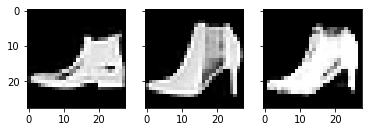

<Figure size 1296x432 with 0 Axes>

In [278]:
i1=2
i2=4
(mu, sigma), _ = model(images[i1].to(device))
z1 = torch.normal(mu, sigma).to(device)
(mu, sigma), _ = model(images[i2].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder((z1+2*z2))
display([images[i1], images[i2], sample], 3)

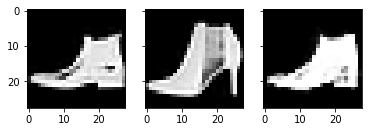

<Figure size 1296x432 with 0 Axes>

In [279]:
i1=2
i2=4
(mu, sigma), _ = model(images[i1].to(device))
z1 = torch.normal(mu, sigma).to(device)
(mu, sigma), _ = model(images[i2].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder((2*z1+z2))
display([images[i1], images[i2], sample], 3)

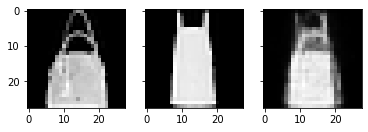

<Figure size 1296x432 with 0 Axes>

In [282]:
i1=3
i2=6
(mu, sigma), _ = model(images[i1].to(device))
z1 = torch.normal(mu, sigma).to(device)
(mu, sigma), _ = model(images[i2].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder((z1+z2)/2)
display([images[i1], images[i2], sample], 3)

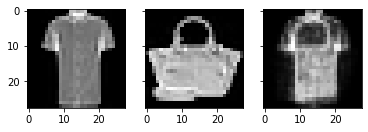

<Figure size 1296x432 with 0 Axes>

In [321]:
i1=10
i2=35
(mu, sigma), _ = model(images[i1].to(device))
z1 = torch.normal(mu, sigma).to(device)
(mu, sigma), _ = model(images[i2].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder((2*z1+z2)/2)
display([images[i1], images[i2], sample], 3)